### Human in the Loop - Approving Tools with Graph.
System ask to use tool and get approval before proceeding to use the tool.
In this instance, the Tavily tool will not be automatically used. System will as for approval to use it first.

In [17]:
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, END
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.prebuilt import ToolNode
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.checkpoint.memory import MemorySaver
from dotenv import load_dotenv

load_dotenv()

True

### Create Tavily tools and Initialize LLM and LLM with tools

In [18]:
memory =MemorySaver()

#Create Tools
search_tool  = TavilySearchResults(max_results=2)
tools = [search_tool]


# llm = ChatGroq(model="llama3-8b-8192")   # 8b model  - faster model
llm = ChatGroq(model="llama3-70b-8192")  # 70b model  x8 better but slower
llm_with_tools= llm.bind_tools(tools=tools)

### Create Nodes

In [19]:
## create the type schema
class BasicChatState(TypedDict):
    messages: Annotated[list, add_messages]

#create chatbot node
def chatbot(state:BasicChatState)->BasicChatState:
    return {
        "messages": [llm_with_tools.invoke(state["messages"])]  #
    }

#create conditional edge (this edge decides movement from chatbot node to either tools node or end)
def tools_router(state:BasicChatState):
    last_message = state["messages"][-1]

    if (hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tools"
    return "stop"

#create a tool node
tool_node =ToolNode(tools=tools)

### Create The Graphs. on compile, add the checkpointer and the interrupt_before parameter
- The interrupt_before parameter tell us when to activate an interrupt when a tool runs
- In this case before a Tavily search runs, there will be an interrupt

In [20]:
#create graph
graph = StateGraph(BasicChatState)

graph.set_entry_point("chatbot")
graph.add_node("chatbot", chatbot)
graph.add_node("tool_node", tool_node)
graph.add_conditional_edges(
    "chatbot",
    tools_router,
{
    "tools":"tool_node",
    "stop": END
})
graph.add_edge("tool_node", "chatbot")

app = graph.compile(checkpointer=memory, interrupt_before=["tool_node"])

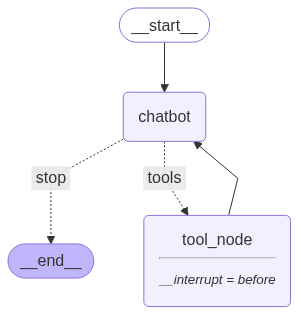

In [21]:
app

### Take user Input and generate the firs result.
- This runs the first node, sees a need to use a tool and then activate the interrupt as specified in interrupt_before
- The output shows the question and then also shows that it is about to run the tool (tavily_search..) then it is stopped by the interrupt
- The stop is to allow user to enter further details befor it continues

In [22]:
configure = {"configurable":
    {"thread_id":1}
}
user_input = input("Question: ")
events = app.stream(
    {"messages": [HumanMessage(content=user_input )]},
    config=configure,
    stream_mode="values"
)


for event in events:
    event["messages"][-1].pretty_print()



Question:  List 5 hot nigeria politics news today


================================ Human Message =================================

List 5 hot nigeria politics news today
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (zbeedjjrv)
 Call ID: zbeedjjrv
  Args:
    query: hot nigeria politics news today


AI: According to the search results, the cheapest flight from Lagos to Abuja on the 30th of July is $66, which is approximately ₦24,120 (based on an exchange rate of 1 USD = 365 NGN).


User:  please check again and give make your converstion 1 USD = 1,575NGN


AI: 1 USD is approximately 1,534.71 NGN.


User:  ok now find me the cheapest flight on the 30th of July, provide me the link and give me the naira price


AI: Based on the tool call result, I found the cheapest flight on the 30th of July. Here is the information:

* Flight from Hamilton (BDA) to Houston (IAH) on 30/07/2025
* Price: US $661* (approximately ₦243,390, based on the current exchange rate)
* Book now on [Allegiant Air](https://www.allegiantair.com/en/july-flight-deals-emcp)

Please note that prices and availability may vary, and I recommend verifying the information with the airline before booking.


User:  list air flights that currently goes from lagos to abuja, provide their website links too


AI: Here is the list of airlines that operate flights from Lagos to Abuja:

1. Arik Air
2. Air Peace
3. Cimber AS
4. Kuwait National Airways
5. NextJet
6. United Nigeria Airlines
7. Real Tonga
8. Overland Airways
9. Val Air
10. Ibom Air
11. Valuejet
12. Aero Nigeria
13. Rano Air
14. American Airlines
15. Delta
16. United Airlines
17. Southwest
18. Alaska Airlines
19. Air Canada
20. British Airways
21. Ryanair
22. Qantas
23. Emirates

Please note that the availability of these airlines may vary depending on the time of year, demand, and other factors. It's always best to check with the airlines or a flight search engine for the most up-to-date and accurate information.


User:  list flight that does local flight from lagos to abuja. also show their url


AI: Here are the local flights from Lagos to Abuja:

1. Arik Air - Non-stop, 1 hour 15 minutes
2. Air Peace - Non-stop, 1 hour 15 minutes
3. NextJet - Non-stop, 1 hour 10 minutes (1 flight per day)
4. UTair-Express - Non-stop, 1 hour 10 minutes (0-1 flights per day, Thursday and Sunday)

Please note that the flight schedules and availability may change, and it's always best to check with the airlines or a travel booking website for the most up-to-date information.

Here are the URLs provided:

1. https://www.flightroutes.com/LOS-ABV
2. https://www.travelstart.com.ng/lp/cheap-flights-from-lagos-to-abuja


User:  exit


### Check which state is next
- this shows we are about to take on the tavily search- which is the next state

In [23]:
snapshot = app.get_state(config=configure)
snapshot.next

('tool_node',)

### give the llm your input. this time we just give NONE so that it procceeds to run the Tavily tool and return the expected result

In [24]:
events = app.stream(None, configure, stream_mode="values")

for event in events:
    print(event["messages"][-1].pretty_print())

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (zbeedjjrv)
 Call ID: zbeedjjrv
  Args:
    query: hot nigeria politics news today
None
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Big shake-up in Nigerian politics as heavyweights join one party", "url": "https://www.yahoo.com/news/big-shake-nigerian-politics-heavyweights-080454828.html", "content": "Manage your account\n\n## Top Stories:\n\nBBC\nBBC\n\n# Big shake-up in Nigerian politics as heavyweights join forces\n\nPeter Obi, on the left hand side of the composite photo, wears a black shirt and black-rimmed glasses. He is smiling in the photo. Atiku Abubakar, on the right hand side, wears glasses, a suit and a patterened tie.\n\nNigeria's two main opposition leaders have joined a new political party to challenge President BolaTinubu and his ruling party in the next election. [..